<a href="https://colab.research.google.com/github/wobiero/malawi_time_series/blob/main/MCCM_TSA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title: Malawi mCCM Trial Intervention Analysis

**Author**: Walter Obiero

**Affiliation**: Global Health Center/US CDC

**Date**: 03/24/24

In [ ]:
# For Bayesian Structural Time Series
#!pip install pycausalimpact

In [ ]:
# For Bayesian regression
#!pip install bambi

In [ ]:
# Ruptures library for breakpoint analysis
#!pip install ruptures

In [ ]:
# For exploratory analysis of Bayesian methods
#!pip install arviz

In [ ]:
# For automatic detection of ARIMA(p,d,q) parameters
# Will use this along with ACF, PACF and augmented Dickey-Fuller tests to choose lags too
#!pip install pmdarima

Import the relevant libraries to be used for the analysis. Will conduct four types: ITSA using OLS; SARIMA; Bayesian ITSA and Bayesian Structural Time Series. The main model will be ITSA while the rest will be used as robustness checks.

In [ ]:
import pmdarima as pm
from pmdarima import model_selection, auto_arima
from datetime import datetime, timedelta

import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.stattools import durbin_watson
import statsmodels.formula.api as smf

from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.arima_process import ArmaProcess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns

from prophet import Prophet
from causalimpact import CausalImpact
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error

import ruptures as rpt
import arviz as az
import bambi as bmb

In [ ]:
# Upload raw data file.
from google.colab import files
uploaded = files.upload()
import io

Saving malawi_analytical_dataset.dta to malawi_analytical_dataset.dta


In [ ]:
# Read dataset and inspect
df = pd.read_stata(io.BytesIO(uploaded["malawi_analytical_dataset.dta"]))
df[:5]

,periodname,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,organisationunitname,clinic,facility_longitude,facility_latitude,copd_micro_u5,...,date2,clinic_id,imci_neg_rdt,imci_pos_rdt,imci_fever,tot_imci_fever,tot_neg_imci_rdt,tot_pos_imci_rdt,tot_copd_rdt_u5,tot_copd_rdt_o5
0,January 2021,MOH MALAWI Govt,Central East Zone,Salima-DHO,Admarc Dispensary,Admarc Dispensary,ADMARC,34.458580,-13.77960,NaN,...,2021-01-01,1.0,26.0,NaN,77.0,4960.0,665.0,2330.0,4438.0,11516.0
1,January 2021,MOH MALAWI Govt,South West Zone,Neno-DHO,Chifunga Health Centre,Chifunga Health Centre,Chifunga,34.709721,-15.62164,NaN,...,2021-01-01,2.0,NaN,NaN,NaN,2460.0,604.0,307.0,6290.0,15660.0
2,January 2021,MOH MALAWI Govt,Central East Zone,Ntchisi-DHO,Chinguluwe Health Centre (Ntchisi),Chinguluwe Health Centre (Ntchisi),Chinguluwe,33.868469,-13.26153,NaN,...,2021-01-01,3.0,118.0,1010.0,1137.0,4960.0,665.0,2330.0,4438.0,11516.0
3,January 2021,MOH MALAWI Govt,Central East Zone,Ntchisi-DHO,Chinthembwe Health Centre,Chinthembwe Health Centre,Chinthembwe,33.908329,-13.42889,NaN,...,2021-01-01,4.0,202.0,307.0,509.0,2460.0,604.0,307.0,6290.0,15660.0
4,January 2021,MOH MALAWI Govt,Central East Zone,Salima-DHO,Chipoka Health Centre,Chipoka Health Centre,Chipoka,34.515560,-13.98950,NaN,...,2021-01-01,5.0,59.0,NaN,241.0,2460.0,604.0,307.0,6290.0,15660.0


In [ ]:
# Get additional information about the dataset
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1440 entries, 0 to 1439
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   periodname                   1440 non-null   object        
 1   orgunitlevel1                1440 non-null   object        
 2   orgunitlevel2                1440 non-null   object        
 3   orgunitlevel3                1440 non-null   object        
 4   orgunitlevel4                1440 non-null   object        
 5   organisationunitname         1440 non-null   object        
 6   clinic                       1440 non-null   object        
 7   facility_longitude           1440 non-null   float32       
 8   facility_latitude            1440 non-null   float32       
 9   copd_micro_u5                111 non-null    float64       
 10  copd_micro_o5                125 non-null    float64       
 11  copd_rdt_u5                  1360 non-null 

In [ ]:
df[['copd_micro_u5','copd_micro_o5', 'copd_rdt_u5', 'copd_rdt_o5', 'sopd_rdt_u5',
       'sopd_rdt_o5', 'sopd_micro_u5', 'sopd_micro_o5']].describe()

,copd_micro_u5,copd_micro_o5,copd_rdt_u5,copd_rdt_o5,sopd_rdt_u5,sopd_rdt_o5,sopd_micro_u5,sopd_micro_o5
count,111.000000,125.000000,1360.000000,1363.000000,1364.000000,1365.000000,133.000000,150.000000
mean,5.396396,9.096000,226.686029,571.159208,474.255865,1047.104762,18.819549,37.106667
std,4.903207,10.609205,265.164110,662.656984,424.432641,966.999341,60.325987,120.603969
min,1.000000,1.000000,1.000000,2.000000,7.000000,29.000000,1.000000,1.000000
25%,2.000000,2.000000,47.000000,121.000000,167.000000,323.000000,3.000000,4.000000
50%,3.000000,6.000000,131.000000,331.000000,351.000000,770.000000,8.000000,9.500000
75%,7.500000,11.000000,316.000000,787.500000,648.250000,1443.000000,17.000000,28.750000
max,24.000000,57.000000,2189.000000,4300.000000,3807.000000,6336.000000,625.000000,1071.000000


In [ ]:
# Drop ADMARC clinic -- did not have OPD attendance during the study period
df = df[~(df["clinic"] == "ADMARC")]
df["clinic"].unique()

array(['Chifunga', 'Chinguluwe', 'Chinthembwe', 'Chipoka', 'Dambe',
       'Kamsonga', 'Kangolwa', 'Kaphatenga', 'Khombedza', 'Lisungwi',
       'Luwani', 'MAFCO', 'Maganga', 'Makion', 'Malambo', 'Malomo',
       'Mkhuzi', 'Neno DHO', 'Nkula', 'Nsambe', 'Nthondo', 'Thavite',
       'Zalewa'], dtype=object)

Check for outliers, address them, and then use linear interpolation to fill in missing gaps in the time series.

In [ ]:
# Function to check indices where there are outliers
def find_outliers(column, threshold=5):
    """
    Find outlier indices in a pandas column using z-score method.

    Parameters:
    column (pandas.Series): The pandas column for which outliers need to be identified.
    threshold (float): The threshold value for z-score. Default is 5.

    Returns:
    list: A list of indices where outliers are found.
    """
    z_scores = np.abs((column - column.mean()) / column.std())
    outlier_indices = np.where(z_scores > threshold)[0]
    return outlier_indices.tolist()

# Check for outliers
outlier_indices = find_outliers(df['copd_rdt_o5'])
print("Indices of outliers:", outlier_indices)


Indices of outliers: [54, 675]


In [ ]:
# Inspect the dataframe to inspect the outliers
df[["clinic", "date2", "copd_rdt_o5"]].iloc[outlier_indices][:]

,clinic,date2,copd_rdt_o5
57,Khombedza,2021-03-01,4039.0
705,Khombedza,2023-06-01,4300.0


On inspection, no outlier looks particularly egregious. Will use the data as is. The choice for linear interpolation was made based on tests in an accompanying notebook.

In [ ]:
# Use linear interpolation to impute missing data
df = df.sort_values(by=["clinic", "date2"], ascending=[True, True])
df["copd_rdt_u5"] = df["copd_rdt_u5"].interpolate(method="linear", limit_direction="forward")
df["copd_rdt_o5"] = df["copd_rdt_o5"].interpolate(method="linear", limit_direction="forward")
df["sopd_rdt_u5"] = df["sopd_rdt_u5"].interpolate(method="linear", limit_direction="forward")
df["sopd_rdt_o5"] = df["sopd_rdt_o5"].interpolate(method="linear", limit_direction="forward")

df["copd_micro_u5"] = df["copd_micro_u5"].interpolate(method="linear", limit_direction="forward")
df["copd_micro_o5"] = df["copd_micro_o5"].interpolate(method="linear", limit_direction="forward")
df["sopd_micro_u5"] = df["sopd_micro_u5"].interpolate(method="linear", limit_direction="forward")
df["sopd_micro_u5"] = df["sopd_micro_u5"].interpolate(method="linear", limit_direction="forward")

In [ ]:
df.columns

Index(['date2', 'study_arm', 'periodname', 'orgunitlevel1', 'orgunitlevel2',
       'orgunitlevel3', 'orgunitlevel4', 'organisationunitname', 'clinic',
       'facility_longitude', 'facility_latitude', 'copd_micro_u5',
       'copd_micro_o5', 'copd_rdt_u5', 'copd_rdt_o5', 'sopd_rdt_u5',
       'sopd_rdt_o5', 'sopd_micro_u5', 'sopd_micro_o5',
       'CHDIMCIFeverNewCases24M', 'CHDIMCIFeverNewCases535M',
       'CHDIMCIFeverNewCases3659M', 'CHDIMCImRDTNegativeNewCases', 'DY', 'DZ',
       'CHDIMCImRDTPositiveNewCases', 'EK', 'EL', 'month', 'year', 'date_new',
       'clinic_id', 'imci_neg_rdt', 'imci_pos_rdt', 'imci_fever',
       'tot_imci_fever', 'tot_neg_imci_rdt', 'tot_pos_imci_rdt',
       'tot_copd_rdt_u5', 'tot_copd_rdt_o5', 'post', 'treat', 'treat_post'],
      dtype='object')

Create columns of combined data by study arm and date. That is, aggregate data by month and study arm. These will be used for the time series analyses

In [ ]:
y = df.groupby(["date2", "study_arm"])["copd_rdt_u5"].sum().reset_index()
z = df.groupby(["date2", "study_arm"])["copd_rdt_o5"].sum().reset_index()
over_5 = z["copd_rdt_o5"].tolist()
under_5 = y["copd_rdt_u5"].tolist()

Collapse dataframe by date and study arm.

In [ ]:
df = df.groupby(["date2", "study_arm"]).first().reset_index()
df["tot_copd_rdt_u5"] = under_5
df["tot_copd_rdt_o5"] = over_5
df[:5]

,date2,study_arm,periodname,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,organisationunitname,clinic,facility_longitude,...,date_new,clinic_id,imci_neg_rdt,imci_pos_rdt,imci_fever,tot_imci_fever,tot_neg_imci_rdt,tot_pos_imci_rdt,tot_copd_rdt_u5,tot_copd_rdt_o5
0,2019-01-01,Control,January 2019,MOH MALAWI Govt,South West Zone,Neno-DHO,Chifunga Health Centre,Chifunga Health Centre,Chifunga,34.709721,...,2019-01-01,2.0,82.0,193.0,301.0,3582.0,746.0,851.0,3158.0,6336.0
1,2019-01-01,Intervention,January 2019,MOH MALAWI Govt,Central East Zone,Ntchisi-DHO,Chinguluwe Health Centre (Ntchisi),Chinguluwe Health Centre (Ntchisi),Chinguluwe,33.868469,...,2019-01-01,3.0,79.0,NaN,412.0,2355.0,622.0,0.0,2365.0,5616.0
2,2019-02-01,Control,February 2019,MOH MALAWI Govt,South West Zone,Neno-DHO,Chifunga Health Centre,Chifunga Health Centre,Chifunga,34.709721,...,2019-02-01,2.0,72.0,141.0,293.0,3534.0,953.0,141.0,1709.0,4682.0
3,2019-02-01,Intervention,February 2019,MOH MALAWI Govt,Central East Zone,Ntchisi-DHO,Chinguluwe Health Centre (Ntchisi),Chinguluwe Health Centre (Ntchisi),Chinguluwe,33.868469,...,2019-02-01,3.0,52.0,NaN,236.0,2052.0,431.0,0.0,1585.0,4002.0
4,2019-03-01,Control,March 2019,MOH MALAWI Govt,South West Zone,Neno-DHO,Chifunga Health Centre,Chifunga Health Centre,Chifunga,34.709721,...,2019-03-01,2.0,42.0,NaN,191.0,3692.0,624.0,0.0,1633.0,4694.0


In [ ]:
# Split dataset into intervention and control for exploratory analyses
intervention = df[df["study_arm"] == "Intervention"]
intervention = intervention.set_index("date2")
intervention.index.freq = "MS"

control = df[df["study_arm"] == "Control"]
control = control.set_index("date2")
control.index.freq = "MS"
#Inspect data
intervention[:5]

,study_arm,periodname,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,organisationunitname,clinic,facility_longitude,facility_latitude,...,date_new,clinic_id,imci_neg_rdt,imci_pos_rdt,imci_fever,tot_imci_fever,tot_neg_imci_rdt,tot_pos_imci_rdt,tot_copd_rdt_u5,tot_copd_rdt_o5
date2,,,,,,,,,,,,,,,,,,,,,
2019-01-01,Intervention,January 2019,MOH MALAWI Govt,Central East Zone,Ntchisi-DHO,Chinguluwe Health Centre (Ntchisi),Chinguluwe Health Centre (Ntchisi),Chinguluwe,33.868469,-13.26153,...,2019-01-01,3.0,79.0,NaN,412.0,2355.0,622.0,0.0,2365.0,5616.0
2019-02-01,Intervention,February 2019,MOH MALAWI Govt,Central East Zone,Ntchisi-DHO,Chinguluwe Health Centre (Ntchisi),Chinguluwe Health Centre (Ntchisi),Chinguluwe,33.868469,-13.26153,...,2019-02-01,3.0,52.0,NaN,236.0,2052.0,431.0,0.0,1585.0,4002.0
2019-03-01,Intervention,March 2019,MOH MALAWI Govt,Central East Zone,Ntchisi-DHO,Chinguluwe Health Centre (Ntchisi),Chinguluwe Health Centre (Ntchisi),Chinguluwe,33.868469,-13.26153,...,2019-03-01,3.0,13.0,132.0,57.0,1923.0,536.0,318.0,1062.0,3083.0
2019-04-01,Intervention,April 2019,MOH MALAWI Govt,Central East Zone,Ntchisi-DHO,Chinguluwe Health Centre (Ntchisi),Chinguluwe Health Centre (Ntchisi),Chinguluwe,33.868469,-13.26153,...,2019-04-01,3.0,115.0,97.0,124.0,1468.0,438.0,97.0,923.0,2428.0
2019-05-01,Intervention,May 2019,MOH MALAWI Govt,Central East Zone,Ntchisi-DHO,Chinguluwe Health Centre (Ntchisi),Chinguluwe Health Centre (Ntchisi),Chinguluwe,33.868469,-13.26153,...,2019-05-01,3.0,44.0,NaN,104.0,755.0,262.0,0.0,939.0,2606.5


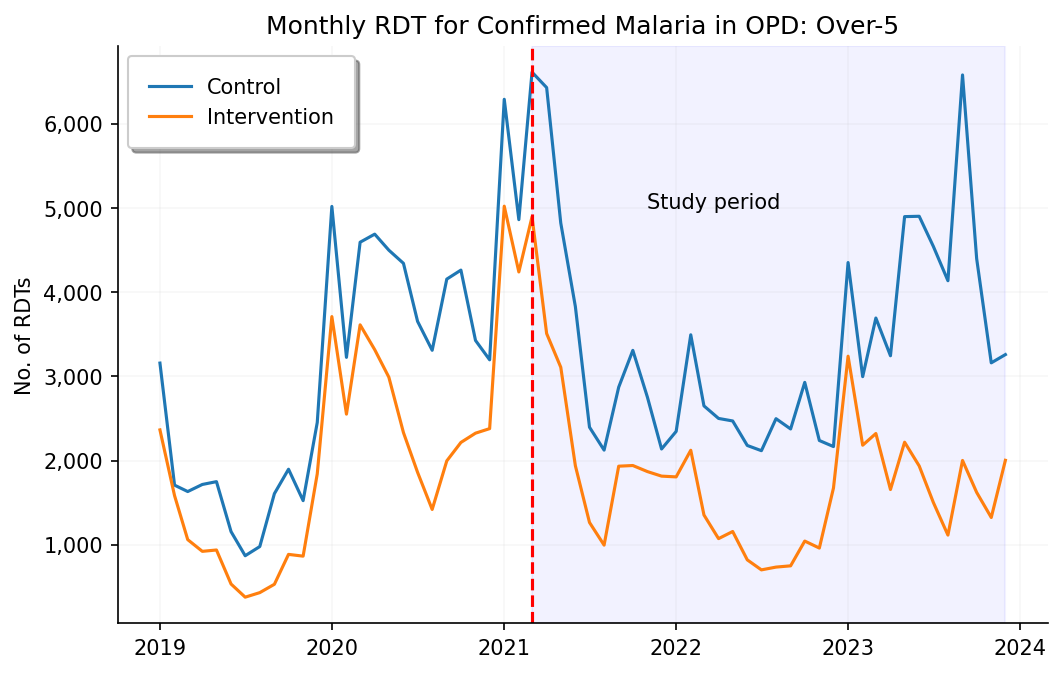

In [ ]:
# Intervention occured in March 2021.
#Visualize series
fig, ax = plt.subplots(figsize=(8,5), dpi=150)
plt.plot(control.index, control["tot_copd_rdt_u5"], label="Control")
plt.plot(intervention.index, intervention["tot_copd_rdt_u5"], label="Intervention")
plt.axvline(x=control.index[26], color="red", ls="--")
plt.xlabel("")
plt.ylabel("No. of RDTs")
plt.legend(loc="best", fancybox=True, shadow=True, borderpad=1)
plt.axvspan(control.index[26], control.index[59], color="blue", alpha=.05)
plt.grid(axis="both", lw=.2, alpha=.4)
plt.title("Monthly RDT for Confirmed Malaria in OPD: Over-5")
plt.text(control.index[34], 5000, "Study period")
for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.savefig("Overall_trends.png", bbox_inches="tight");

Decompose time series to check for trends and seasonal patterns.
Will only show some of the figures for space considerations

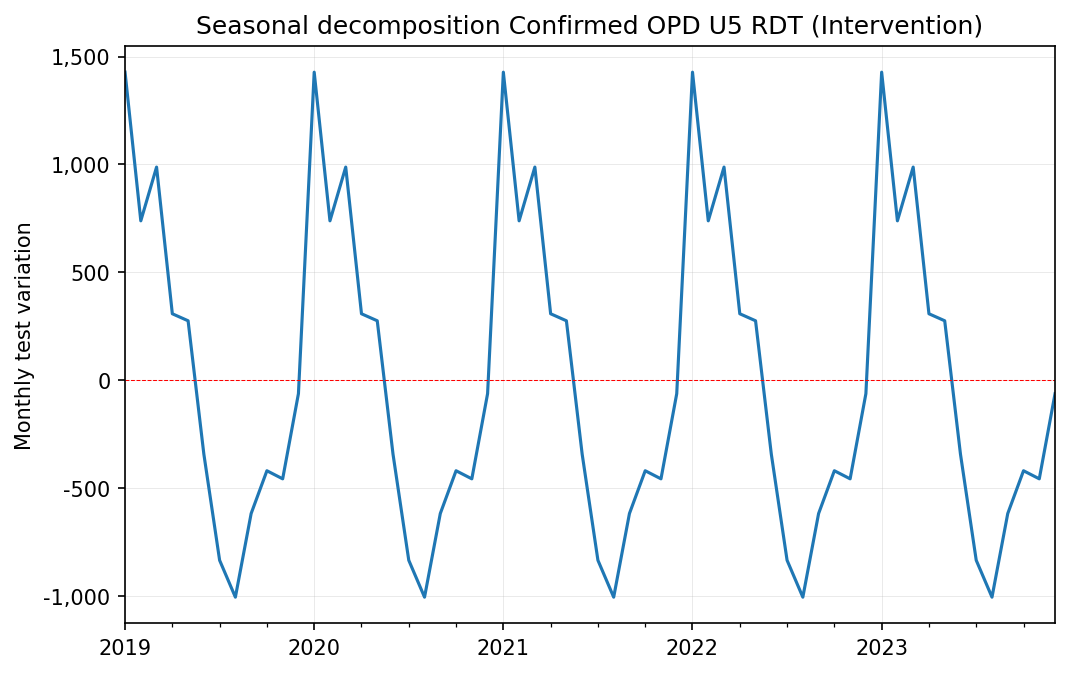

In [ ]:
fig, ax = plt.subplots(figsize=(8,5), dpi=150)
seasonal_decompose(intervention["tot_copd_rdt_u5"], model="additive").seasonal.plot()
plt.title("Seasonal decomposition Confirmed OPD U5 RDT (Intervention)")
plt.xlabel("")
plt.ylabel("Monthly test variation")
plt.axhline(ls="--", lw=.5, color="red")
#ax.xaxis.set_minor_locator(AutoMinorLocator(12))
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=.2)
plt.grid(axis="both", lw=.4, alpha=.3)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.savefig("seasonal_conf_rdt_u5_inter.png", bbox_inches="tight");

There appears to be a seasonal pattern in Malaria starting from around November through March. Malawi team to confirm if this is the case.

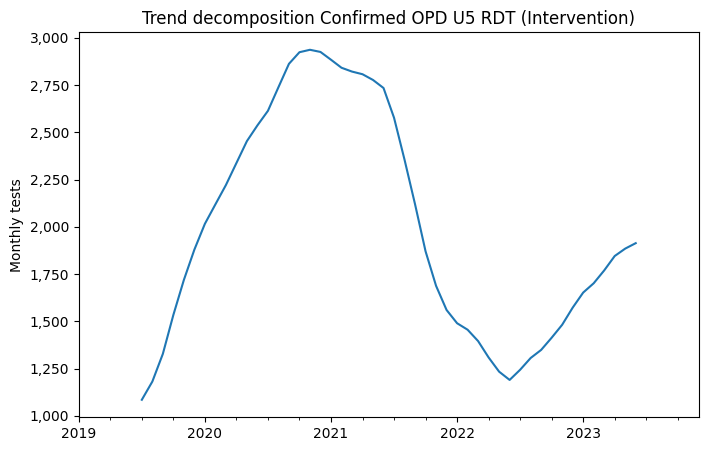

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
seasonal_decompose(intervention["tot_copd_rdt_u5"], model="additive").trend.plot()
plt.title("Trend decomposition Confirmed OPD U5 RDT (Intervention)")
plt.xlabel("")
plt.ylabel("Monthly tests")
#ax.xaxis.set_minor_locator(AutoMinorLocator(12))
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=.2)
#plt.grid(axis="both", alpha=.5)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.savefig("trend_conf_rdt_u5_inter.png", bbox_inches="tight");

In [ ]:
files.download("trend_conf_rdt_u5_inter.png")
files.download("seasonal_conf_rdt_u5_inter.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

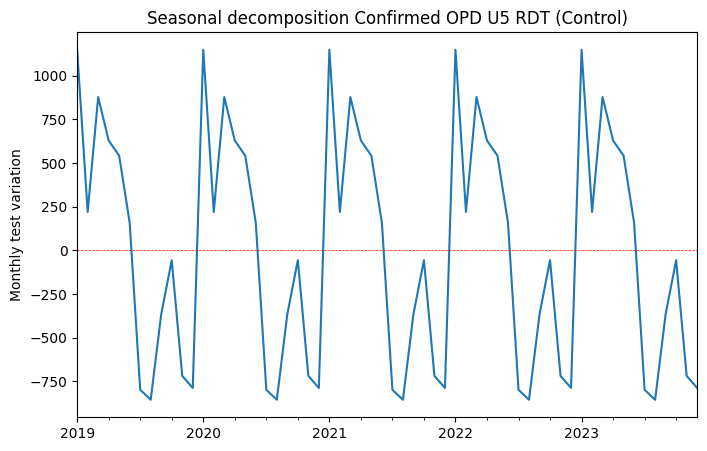

In [ ]:
# Seasonal decomposition control arm
fig, ax = plt.subplots(figsize=(8,5))
seasonal_decompose(control["tot_copd_rdt_u5"], model="additive").seasonal.plot()
plt.title("Seasonal decomposition Confirmed OPD U5 RDT (Control)")
plt.xlabel("")
plt.ylabel("Monthly test variation")
plt.axhline(ls="--", lw=.5, color="red")
plt.savefig("seasonal_u5_opd_confirmed_control.png", bbox_inches="tight");

In [ ]:
files.download("seasonal_u5_opd_confirmed_control.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

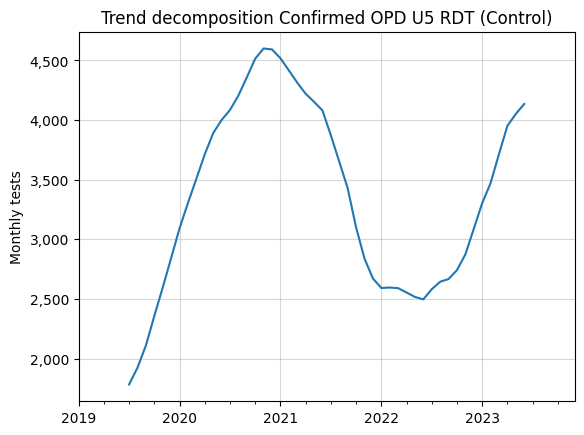

In [ ]:
# Trends in the control group
seasonal_decompose(control["tot_copd_rdt_u5"], model="additive").trend.plot()
plt.title("Trend decomposition Confirmed OPD U5 RDT (Control)")
plt.xlabel("")
plt.ylabel("Monthly tests")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.grid(axis="both", alpha=.5);

The trend plots suggest minimal impact. Check for lags.

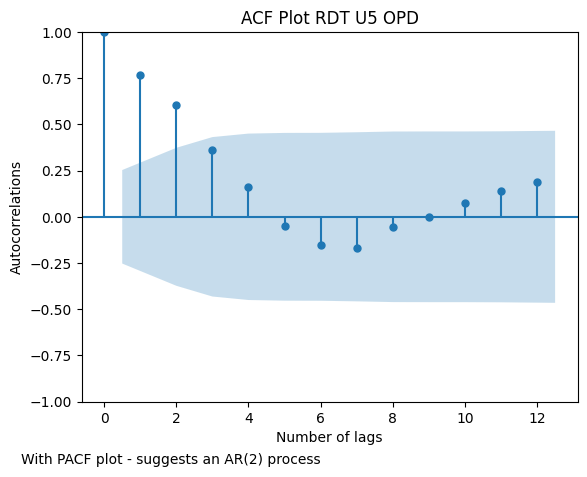

In [ ]:
# Autocorrelation analysis
plot_acf(intervention["tot_copd_rdt_u5"], lags=12)
plt.xlabel("Number of lags")
plt.title("ACF Plot RDT U5 OPD")
plt.ylabel("Autocorrelations")
plt.figtext(.03, -.02, "With PACF plot - suggests an AR(2) process", ha="left")
plt.savefig("acf_rdt_u5_confirm.png", bbox_inches="tight");

In [ ]:
files.download("acf_rdt_u5_confirm.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

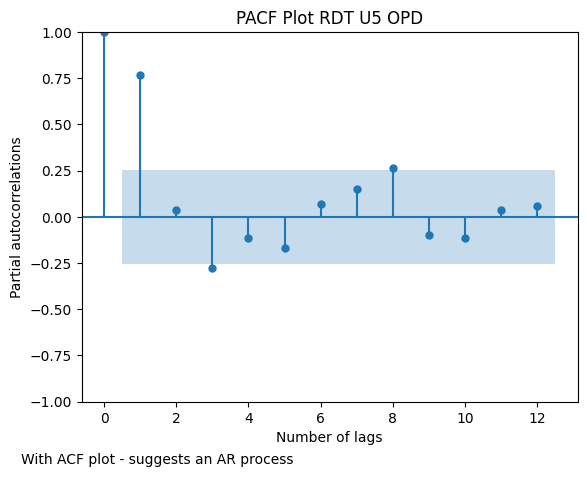

In [ ]:
#Partial autocorrelation analysis
plot_pacf(intervention["tot_copd_rdt_u5"], lags=12)
plt.xlabel("Number of lags")
plt.title("PACF Plot RDT U5 OPD")
plt.ylabel("Partial autocorrelations")
plt.figtext(.03, -.02, "With ACF plot - suggests an AR process", ha="left")
plt.savefig("pacf_rdt_u5_confirm.png", bbox_inches="tight");

In [ ]:
files.download("pacf_rdt_u5_confirm.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Check for stationarity and number of lags
# Run an augmented Dickey Fuller test on the columns

def adf_test(column):
    """
    Perform Augmented Dickey-Fuller test on a pandas column.

    Parameters:
    column (pandas.Series): The pandas column to perform the test on.

    Returns:
    tuple: A tuple containing the test statistic, p-value, and other test statistics.
    """
    result = adfuller(column, autolag="AIC")
    return result

# Assuming 'df' is your DataFrame and 'column_name' is the name of the column
result = adf_test(intervention['tot_copd_rdt_u5'])

# Printing the results
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])
print("Test Statistics:", result[3])


Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary
ADF Statistic: -3.0900131554257926
p-value: 0.027301141893630396
Critical Values: {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
Test Statistics: 57


The ADF test results suggest that the series is stationary.

Will use one lag for the analysis.

In [ ]:
#Recheck lags using the auto arima function
pm.auto_arima(intervention["tot_copd_rdt_u5"], error_action="ignore",
              trace=True, suppress_warnings=True, maxiter=10, seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=958.272, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1008.326, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=954.047, Time=0.41 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=986.344, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1093.192, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=957.639, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=955.673, Time=0.45 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=955.834, Time=0.24 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=954.226, Time=0.21 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=956.624, Time=0.28 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1009.886, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=955.739, Time=0.13 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=956.356, Time=0.12 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=987.452, Time=0.11 sec
 ARIMA(2,0,1)(1,0,0)[12] inter

ARIMA(maxiter=10, order=(1, 0, 0), scoring_args={},
      seasonal_order=(1, 0, 0, 12), suppress_warnings=True)

# **Conduct Bayesian Structural Time Series**

Use the Python package causalinference for this.
[Bradesen et. al](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/41854.pdf)

**Under-5 Analysis**

In [ ]:
# Generate a subset of the data
# The control group will act as control
ci_inter = intervention[["tot_copd_rdt_u5"]].copy()
ci_inter["c_tot_copd_rdt_u5"] = control["tot_copd_rdt_u5"]
ci_inter[:5]

,tot_copd_rdt_u5,c_tot_copd_rdt_u5
date2,,
2019-01-01,2365.0,3158.0
2019-02-01,1585.0,1709.0
2019-03-01,1062.0,1633.0
2019-04-01,923.0,1717.0
2019-05-01,939.0,1750.5


In [ ]:
# Set pre-period
# Intervention started in March 2021
pre_period = [str(ci_inter.index.min())[:26], str(ci_inter.index[26])[:26]]

# Set post-period
post_period = [str(ci_inter.index[27])[:27], str(ci_inter.index.max())[:27]]

# Print out the values
print(f'The pre-period is {pre_period}')
print(f'The post-period is {post_period}')

The pre-period is ['2019-01-01 00:00:00', '2021-03-01 00:00:00']
The post-period is ['2021-04-01 00:00:00', '2023-12-01 00:00:00']


In [ ]:
# Check the means of the intervention and control group
pre_avg_int = ci_inter["tot_copd_rdt_u5"][:26].mean()
post_avg_int = ci_inter["tot_copd_rdt_u5"][26:].mean()
print(f"The mean number of RDTs was {pre_avg_int:,.2f} in the pre-period, and {post_avg_int:,.2f} in the post-period in the intervention arm.")


The mean number of RDTs was 2,012.52 in the pre-period, and 1,782.97 in the post-period in the intervention arm.


In [ ]:
pre_avg_ctrl = ci_inter["c_tot_copd_rdt_u5"][:26].mean()
post_avg_ctrl = ci_inter["c_tot_copd_rdt_u5"][26:].mean()
print(f"The mean number of RDTs was {pre_avg_ctrl:,.2f} in the pre-period, and {post_avg_ctrl:,.2f} in the post-period in the control arm.")


The mean number of RDTs was 3,076.23 in the pre-period, and 3,453.44 in the post-period in the control arm.


In [ ]:
# A diff-in-diff estimate would be:
print(f"The simple DID estimate is: {(post_avg_int - pre_avg_int)-(post_avg_ctrl - pre_avg_ctrl):,.2f} cases")

The simple DID estimate is: -606.76 cases


In [ ]:
#Note that the dataframe - df- has already been collapsed.
# Generate a post column as well as an interaction term
df["treat"] = df["study_arm"].map({"Control": 0, "Intervention": 1}).astype(int)
df["post"] = (df["date2"] >= pd.Timestamp("2021-03-01")).astype(int)
df["treat_post"] = df["treat"] * df["post"]
df[["date2", "post", "treat", "treat_post"]][40:60]

,date2,post,treat,treat_post
40,2020-09-01,0,0,0
41,2020-09-01,0,1,0
42,2020-10-01,0,0,0
43,2020-10-01,0,1,0
44,2020-11-01,0,0,0
45,2020-11-01,0,1,0
46,2020-12-01,0,0,0
47,2020-12-01,0,1,0
48,2021-01-01,0,0,0
49,2021-01-01,0,1,0


In [ ]:
# Run OLS (DID regression)
# Added month dummies and robust standard errors
model = smf.ols(formula = "tot_copd_rdt_u5 ~ treat + post + treat_post + C(month)", data=df)
res = model.fit(cov_type="HC3") # Robust standard errors
print("DID Regression-- Under 5 RDT Confirmed")
print(res.summary())

DID Regression-- Under 5 RDT Confirmed
                            OLS Regression Results                            
Dep. Variable:        tot_copd_rdt_u5   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     4.889
Date:                Wed, 27 Mar 2024   Prob (F-statistic):           6.96e-07
Time:                        12:33:45   Log-Likelihood:                -1008.7
No. Observations:                 120   AIC:                             2047.
Df Residuals:                     105   BIC:                             2089.
Df Model:                          14                                         
Covariance Type:                  HC3                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------

**Run the causal impact model**

/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: nseasons, standardize. After release 0.14, this will raise.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)



------------------------------------------------------------------------
Under-5 Confirmed Malaria Cases RDT
------------------------------------------------------------------------


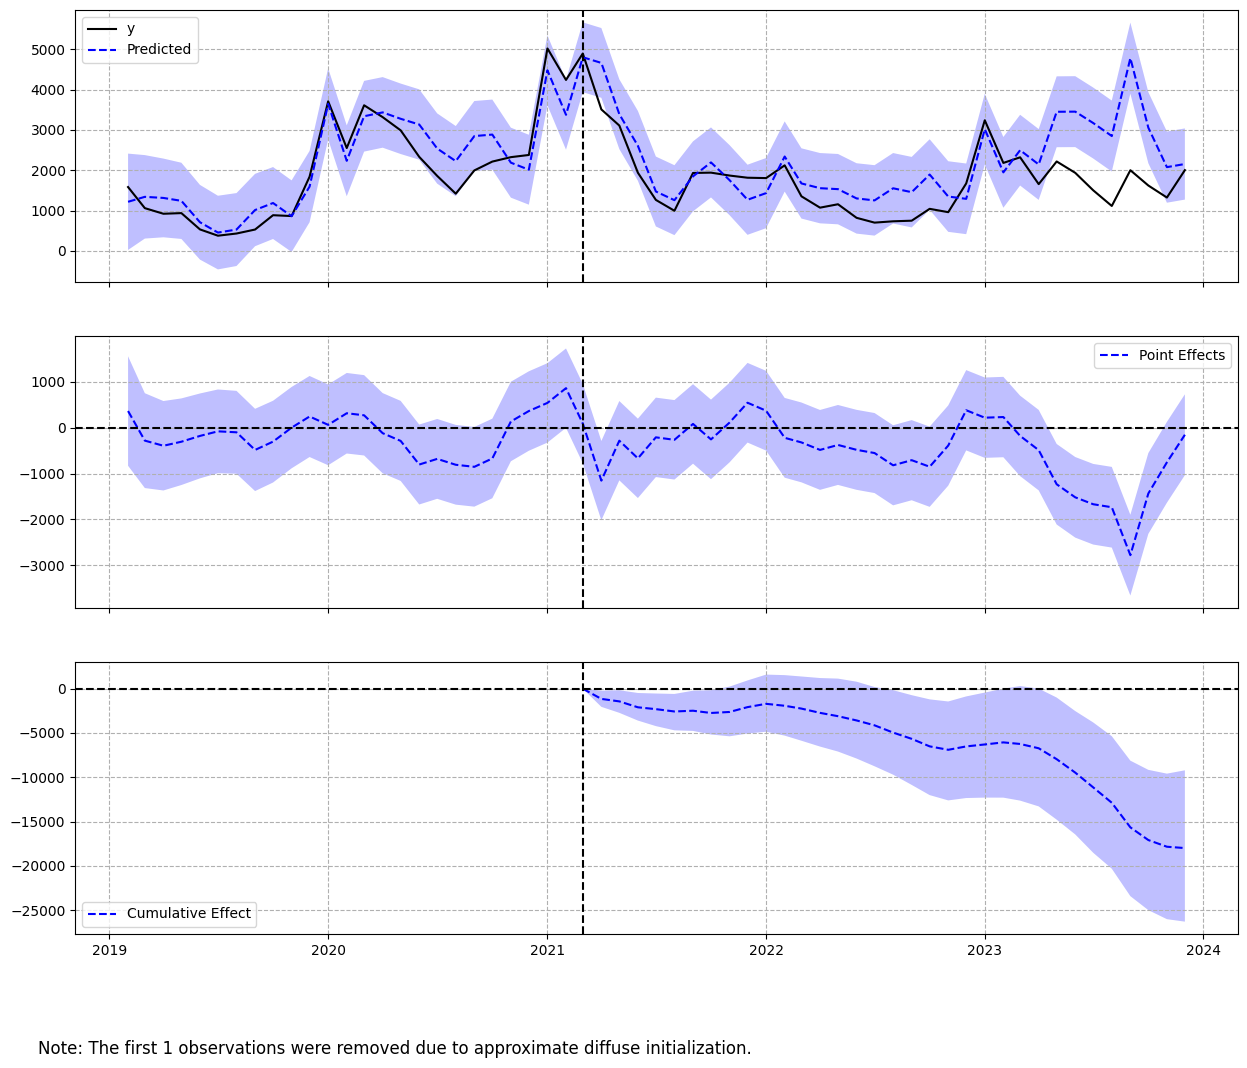

In [ ]:
impact = CausalImpact(data=ci_inter, pre_period= pre_period, post_period=post_period)
title = "Under-5 Confirmed Malaria Cases RDT"
print("")
print("------------------------------------------------------------------------")
print(f"{title:^30s}")
print("------------------------------------------------------------------------")
impact.plot();

In [ ]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1688.67            55726.0
Prediction (s.d.)         2233.92 (132.07)   73719.38 (4358.43)
95% CI                    [1967.9, 2485.62]  [64940.73, 82025.47]

Absolute effect (s.d.)    -545.25 (132.07)   -17993.38 (4358.43)
95% CI                    [-796.95, -279.23] [-26299.47, -9214.73]

Relative effect (s.d.)    -24.41% (5.91%)    -24.41% (5.91%)
95% CI                    [-35.68%, -12.5%]  [-35.68%, -12.5%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [ ]:
# The causalimpact package does not give means and confidence intervals of the post period
# Have to calculate manually using scipy

list_x = impact.inferences['point_effects'][26:].tolist()
list_y = [list_x[i] - list_x[i-1] for i in range(1, len(list_x))]
mean_post = np.mean(list_y)
ci_post = stats.t.interval(confidence=.95,
                           df=len(list_y) - 1,
                           loc = mean_post,
                           scale=stats.sem(list_y))
#impact.inferences
print(mean_post, ci_post)

-7.419700627931792 (-198.17785192393168, 183.33845066806808)


In [ ]:
print(impact.summary("report"))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 1688.67. By contrast, in the absence of an
intervention, we would have expected an average response of 2233.92.
The 95% interval of this counterfactual prediction is [1982.29, 2486.21].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -545.25 with a 95% interval of
[-797.54, -293.62]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 55726.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 73719.38. The 95% interval of this prediction is [65415.54, 82044.77].


The above results are given in terms of absolute numbers. In relative
terms

**Repeat analysis for over-5**

In [ ]:
#Causal Impact analysis
ci_inter = intervention[["tot_copd_rdt_o5"]].copy()
ci_inter["c_tot_copd_rdt_o5"] = control["tot_copd_rdt_o5"]

In [ ]:
# Set pre-period
# Intervention started in March 2021
pre_period = [str(ci_inter.index.min())[:26], str(ci_inter.index[26])[:26]]

# Set post-period
post_period = [str(ci_inter.index[27])[:27], str(ci_inter.index.max())[:27]]

# Print out the values
print(f'The pre-period is {pre_period}')
print(f'The post-period is {post_period}')

The pre-period is ['2019-01-01 00:00:00', '2021-03-01 00:00:00']
The post-period is ['2021-04-01 00:00:00', '2023-12-01 00:00:00']


In [ ]:
pre_avg_int = ci_inter["tot_copd_rdt_o5"][:26].mean()
post_avg_int = ci_inter["tot_copd_rdt_o5"][26:].mean()
print(f"The mean number of RDTs was {pre_avg_int:,.2f} in the pre-period, and {post_avg_int:,.2f} in the post-period in the intervention arm.")


The mean number of RDTs was 4,712.87 in the pre-period, and 4,882.54 in the post-period in the intervention arm.


In [ ]:
pre_avg_ctrl = ci_inter["c_tot_copd_rdt_o5"][:26].mean()
post_avg_ctrl = ci_inter["c_tot_copd_rdt_o5"][26:].mean()
print(f"The mean number of RDTs was {pre_avg_ctrl:,.2f} in the pre-period, and {post_avg_ctrl:,.2f} in the post-period in the control arm.")


The mean number of RDTs was 6,713.88 in the pre-period, and 9,412.53 in the post-period in the control arm.


Note that the differences in the pre-post for both control and intervention group means reduces to a 2X2 diff-in-diff.  Which can also be verified using a regression.

In [ ]:
# A diff-in-diff estimate would be:
print(f"The simple DID estimate is: {(post_avg_int - pre_avg_int)-(post_avg_ctrl - pre_avg_ctrl):,.2f} cases")

The simple DID estimate is: -2,528.97 cases


In [ ]:
# Run OLS (DID regression)
# Added month dummies and robust standard errors
model = smf.ols(formula = "tot_copd_rdt_o5 ~ treat + post + treat_post + C(month)", data=df)
res = model.fit(cov_type="HC3") # Robust standard errors
print("DID Regression-- Over 5 RDT Confirmed")
print(res.summary())


DID Regression-- Over 5 RDT Confirmed
                            OLS Regression Results                            
Dep. Variable:        tot_copd_rdt_o5   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     7.465
Date:                Wed, 27 Mar 2024   Prob (F-statistic):           1.31e-10
Time:                        12:28:40   Log-Likelihood:                -1123.3
No. Observations:                 120   AIC:                             2277.
Df Residuals:                     105   BIC:                             2318.
Df Model:                          14                                         
Covariance Type:                  HC3                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

The results suggest lower cases being seen at the facilities. Note that the statistical analysis plan calls for the use of time series approaches, so the DID example here is inappropriate.

**Run causal inference**

/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: nseasons, standardize. After release 0.14, this will raise.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)



------------------------------------------------------------------------
Over-5 Confirmed Malaria Cases RDT
------------------------------------------------------------------------


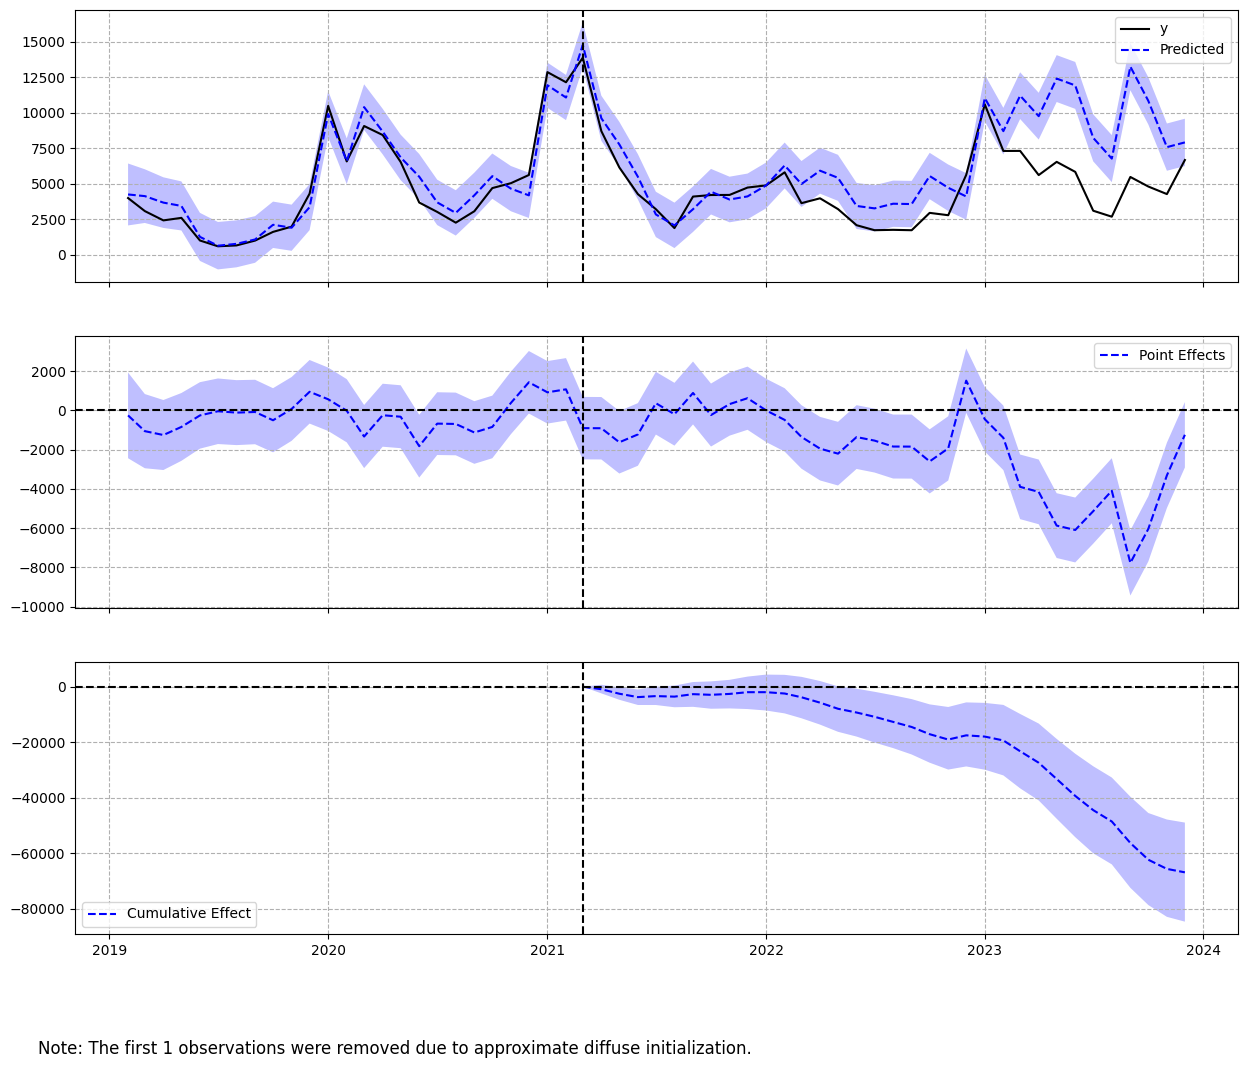

In [ ]:
impact = CausalImpact(data=ci_inter, pre_period= pre_period, post_period=post_period)
title = "Over-5 Confirmed Malaria Cases RDT"
print("")
print("------------------------------------------------------------------------")
print(f"{title:^30s}")
print("------------------------------------------------------------------------")
impact.plot();

In [ ]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    4609.74            152121.5
Prediction (s.d.)         6638.44 (277.46)   219068.41 (9156.27)
95% CI                    [6097.35, 7184.99] [201212.7, 237104.61]

Absolute effect (s.d.)    -2028.69 (277.46)  -66946.91 (9156.27)
95% CI                    [-2575.25, -1487.61][-84983.11, -49091.2]

Relative effect (s.d.)    -30.56% (4.18%)    -30.56% (4.18%)
95% CI                    [-38.79%, -22.41%] [-38.79%, -22.41%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [ ]:
# The causalimpact package does not give means and confidence intervals of the post period
# Have to calculate manually using scipy

list_x = impact.inferences['point_effects'][26:].tolist()
list_y = [list_x[i] - list_x[i-1] for i in range(1, len(list_x))]
mean_post = np.mean(list_y)
ci_post = stats.t.interval(confidence=.95,
                           df=len(list_y) - 1,
                           loc = mean_post,
                           scale=stats.sem(list_y))
#impact.inferences
print(mean_post, ci_post)

-10.2773336247279 (-520.3402836505044, 499.78561640104857)


In [ ]:
print(impact.summary("report"))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 4609.74. By contrast, in the absence of an
intervention, we would have expected an average response of 6638.44.
The 95% interval of this counterfactual prediction is [6059.6, 7177.63].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -2028.69 with a 95% interval of
[-2567.89, -1449.86]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 152121.5.
By contrast, had the intervention not taken place, we would have expected
a sum of 219068.41. The 95% interval of this prediction is [199966.81, 236861.82].


The above results are given in terms of absolute numbers. In relative

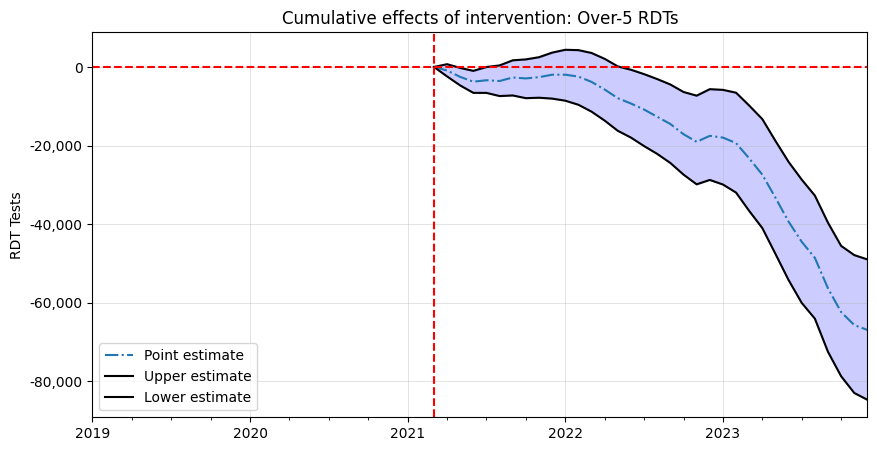

In [ ]:
fig,ax = plt.subplots(figsize=(10,5), dpi=100)
impact.inferences["post_cum_effects"].plot(style="-.")
impact.inferences["post_cum_effects_upper"].plot(style="-", color="k")
impact.inferences["post_cum_effects_lower"].plot(style="-", color="k")
plt.axhline(0, ls="--", color="r")
plt.axvline(ci_inter.index[26], ls="--", color="r")
plt.xlabel("")
plt.ylabel("RDT Tests")
plt.title("Cumulative effects of intervention: Over-5 RDTs")
plt.fill_between(ci_inter.index,
                 impact.inferences["post_cum_effects_lower"],
                 impact.inferences["post_cum_effects_upper"],
                 color="blue", alpha=.2
                 )
plt.grid(axis="both", lw=.5, alpha=.5)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.legend(labels=["Point estimate", "Upper estimate", "Lower estimate"],
           loc="best", fancybox=True)
plt.savefig("o5_btsa.png", bbox_inches="tight");

In [ ]:
files.download("o5_btsa.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Conduct Interrupted Time Series Analyses**

In [ ]:
ci_inter["T"] = np.arange(len(ci_inter)) + 1
ci_inter["T"] = ci_inter["T"].astype(float)
ci_inter["study"] = np.where(ci_inter["T"] > 25, 1, 0)
ci_inter["post"] = (ci_inter["T"]-25 - 1).clip(lower=0)
ci_inter["month"] = ci_inter.index.month

In [ ]:
# This is an ITSA model with 1 lag and Newey-West Standard errors and without small sample correction
# The lag was chosen from a combination of the auto arima model, ACF and PACF plots above
model = smf.ols(formula = "tot_copd_rdt_o5 ~ T + study + post +C(month)", data=ci_inter)
res = model.fit(cov_type="HAC", cov_kwds={"maxlags":1})
print("Interrupted time series analysis -- Over 5 RDT Confirmed")
print(res.summary())

Interrupted time series analysis -- Over 5 RDT Confirmed
                            OLS Regression Results                            
Dep. Variable:        tot_copd_rdt_o5   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     13.29
Date:                Mon, 25 Mar 2024   Prob (F-statistic):           1.26e-11
Time:                        14:24:50   Log-Likelihood:                -529.42
No. Observations:                  60   AIC:                             1089.
Df Residuals:                      45   BIC:                             1120.
Df Model:                          14                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

Note: The BSTS estimated a drop in RDTs offered in health facilities at -2028.69[-2579.83, -1466.3]. The ITSA approach estimates -2179.32[-4127.09, -231.55]. The estimates differ slightly but the directionality is maintained.

Get predictions and plot the counterfactual

In [ ]:
start = 27
end = 59
predictions = res.get_prediction(ci_inter)
summary = predictions.summary_frame(alpha=.05)
y_pred = predictions.predicted_mean

cf_df = ci_inter.copy()
cf_df["shock"] = 0.0
cf_df["post"] = 0.0

cf = res.get_prediction(cf_df).summary_frame(alpha=.05)
cf[:5]

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,5379.879901,1063.775044,3294.919127,7464.840674,1115.621459,9644.138343
1,4206.173992,681.693989,2870.078325,5542.269658,253.707640,8158.640343
2,4597.869406,1251.730172,2144.523350,7051.215461,141.890782,9053.848029
3,3198.298153,784.774077,1660.169227,4736.427079,-826.957022,7223.553328
4,2542.426900,620.524282,1326.221655,3758.632145,-1371.138460,6455.992260


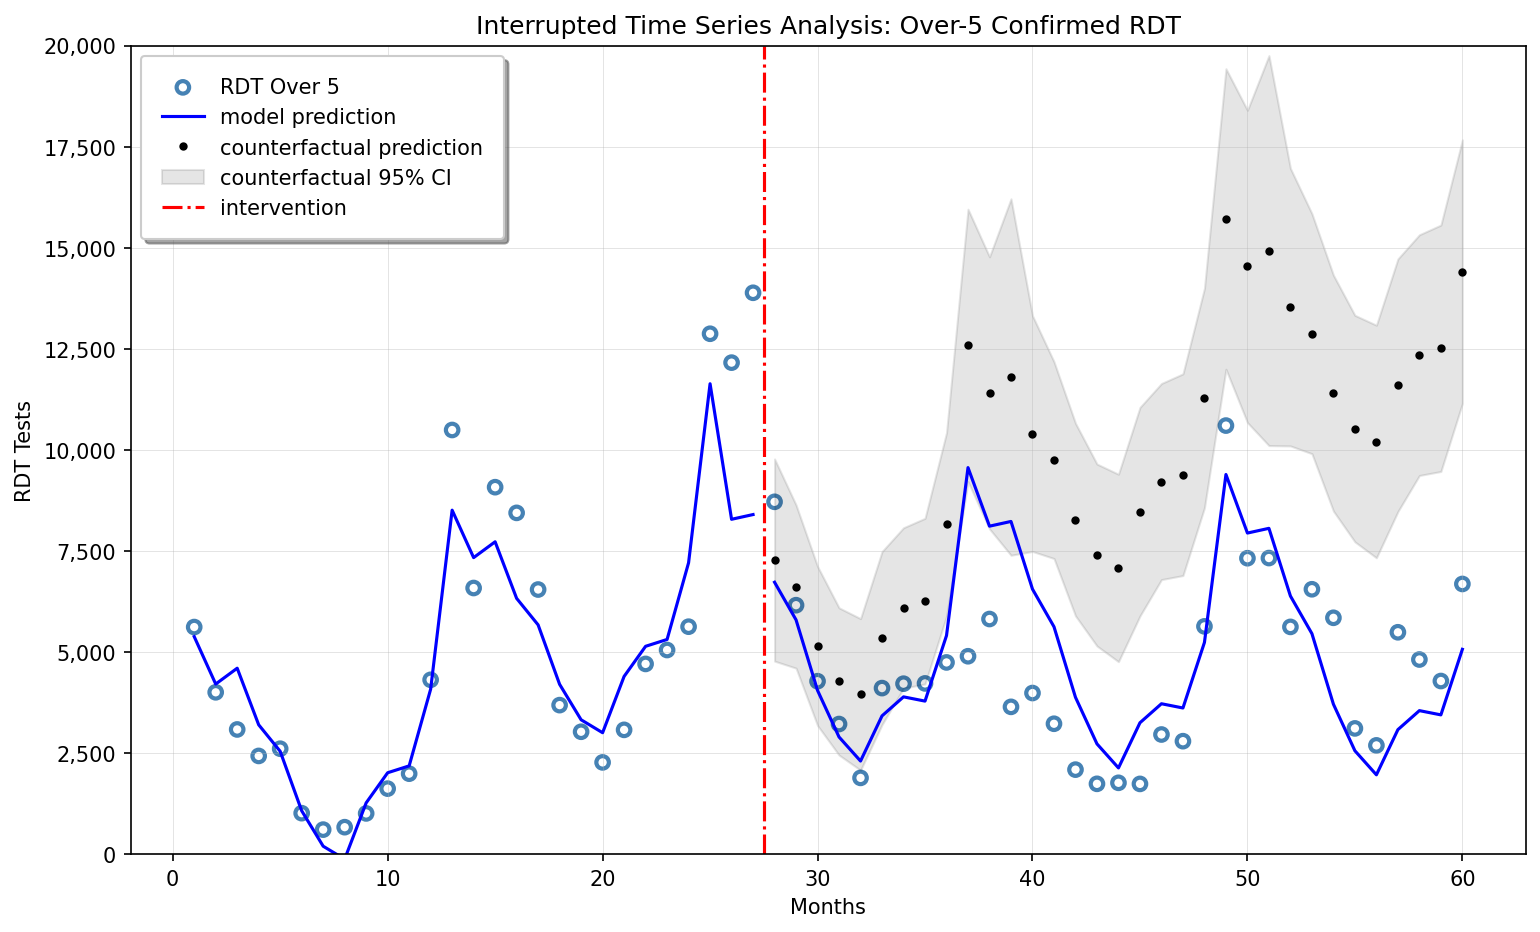

In [ ]:
fig, ax = plt.subplots(figsize=(12,7), dpi=150)
ax.scatter(ci_inter["T"], ci_inter["tot_copd_rdt_o5"], facecolors="none",
          edgecolors="steelblue", label="RDT Over 5", linewidths=2)
ax.plot(ci_inter["T"][:start], y_pred[:start], "b-", label="model prediction")
ax.plot(ci_inter["T"][start:], y_pred[start:], "b-", )
ax.plot(ci_inter["T"][start:], cf["mean"][start:], "k.", label="counterfactual prediction")
ax.fill_between(ci_inter["T"][start:], cf["mean_ci_lower"][start:],
                cf["mean_ci_upper"][start:], color="k", alpha=.1, label="counterfactual 95% CI")
ax.axvline(x = start + .5, color = "r", linestyle="-.", label="intervention")
ax.legend(loc="upper left", shadow=True, fancybox=True, borderpad=1)
plt.ylim([0, 20000])
plt.xlabel("Months")
plt.ylabel("RDT Tests")
plt.grid(axis="both", lw=.4, alpha=.4)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.title("Interrupted Time Series Analysis: Over-5 Confirmed RDT");

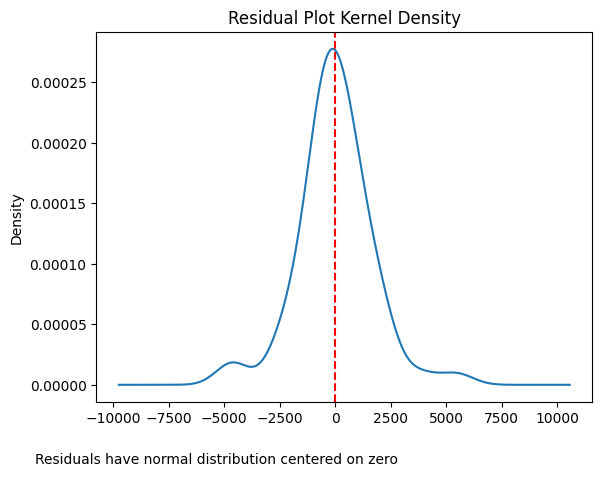

In [ ]:
# The post-ITSA residual plot is neatly spread around zero
# Comfortable with post-regression diagnostics
res.resid.plot(kind="kde")
plt.title("Residual Plot Kernel Density")
plt.figtext(.03, -.02, "Residuals have normal distribution centered on zero")
plt.axvline(0, ls="--", color="r")

# **Repeat ITSA for Under-5**

In [ ]:
ci_inter_u = intervention[["tot_copd_rdt_u5"]].copy()
ci_inter_u["c_tot_copd_rdt_u5"] = control["tot_copd_rdt_u5"]
ci_inter_u["T"] = np.arange(len(ci_inter_u)) + 1
ci_inter_u["T"] = ci_inter_u["T"].astype(float)
ci_inter_u["study"] = np.where(ci_inter_u["T"] > 25, 1, 0)
ci_inter_u["post"] = (ci_inter_u["T"]-25 - 1).clip(lower=0)
ci_inter_u["month"] = ci_inter_u.index.month
ci_inter_u[:5]

,tot_copd_rdt_u5,c_tot_copd_rdt_u5,T,study,post,month
date2,,,,,,
2019-01-01,2365.0,3158.0,1.0,0,0.0,1
2019-02-01,1585.0,1709.0,2.0,0,0.0,2
2019-03-01,1062.0,1633.0,3.0,0,0.0,3
2019-04-01,923.0,1717.0,4.0,0,0.0,4
2019-05-01,939.0,1750.5,5.0,0,0.0,5


In [ ]:
# This is an ITSA model with 1 lag and Newey-West Standard errors and without small sample correction
# The lag was chosen from a combination of the auto arima model, ACF and PACF plots above
model = smf.ols(formula = "tot_copd_rdt_u5 ~ T + study + post +C(month)", data=ci_inter_u)
res = model.fit(cov_type="HAC", cov_kwds={"maxlags":1})
print("Interrupted time series analysis -- Under 5 RDT Confirmed")
print(res.summary())

Interrupted time series analysis -- Under 5 RDT Confirmed
                            OLS Regression Results                            
Dep. Variable:        tot_copd_rdt_u5   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     13.60
Date:                Mon, 25 Mar 2024   Prob (F-statistic):           8.51e-12
Time:                        14:25:12   Log-Likelihood:                -469.11
No. Observations:                  60   AIC:                             968.2
Df Residuals:                      45   BIC:                             999.6
Df Model:                          14                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

In [ ]:
start = 27
end = 59
predictions = res.get_prediction(ci_inter_u)
summary = predictions.summary_frame(alpha=.05)
y_pred = predictions.predicted_mean

cf_df = ci_inter.copy()
cf_df["shock"] = 0.0
cf_df["post"] = 0.0

cf = res.get_prediction(cf_df).summary_frame(alpha=.05)
cf[:5]

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,1827.162615,391.647591,1059.547442,2594.777788,264.239852,3390.085378
1,1410.086438,238.081761,943.454761,1876.718116,-29.093756,2849.266633
2,1606.058190,421.417036,780.095977,2432.020404,13.667507,3198.448873
3,1136.296608,323.109952,503.012740,1769.580477,-365.216951,2637.810167
4,1206.835027,274.058516,669.690205,1743.979848,-256.728798,2670.398851


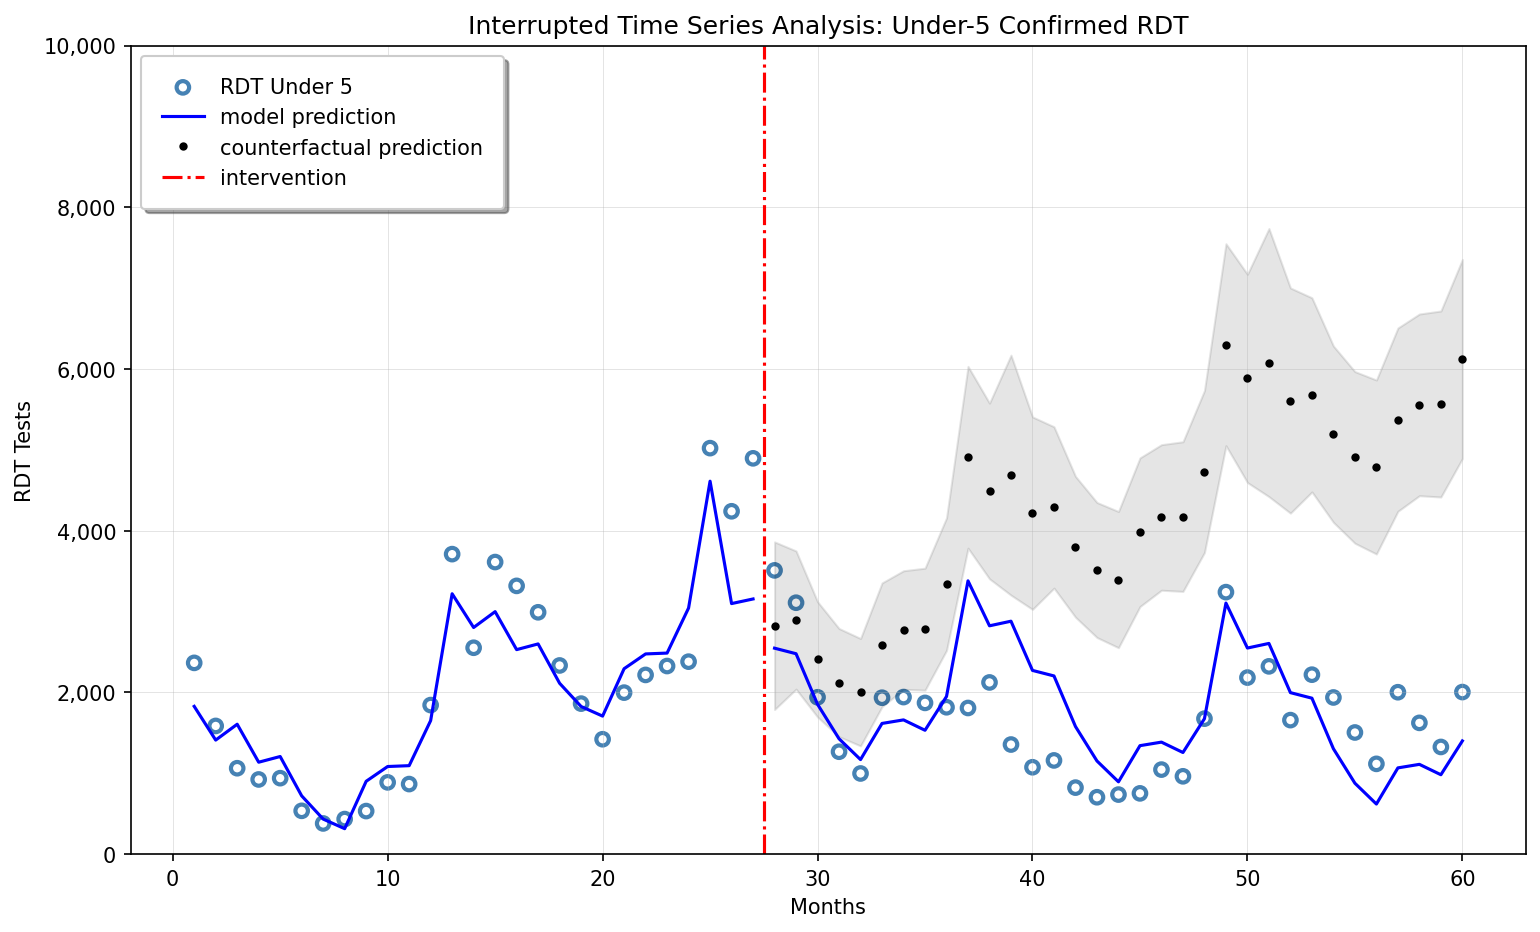

In [ ]:
fig, ax = plt.subplots(figsize=(12,7), dpi=150)
ax.scatter(ci_inter_u["T"], ci_inter_u["tot_copd_rdt_u5"], facecolors="none",
          edgecolors="steelblue", label="RDT Under 5", linewidths=2)
ax.plot(ci_inter_u["T"][:start], y_pred[:start], "b-", label="model prediction")
ax.plot(ci_inter_u["T"][start:], y_pred[start:], "b-", )
ax.plot(ci_inter_u["T"][start:], cf["mean"][start:], "k.", label="counterfactual prediction")
ax.fill_between(ci_inter_u["T"][start:], cf["mean_ci_lower"][start:],
                cf["mean_ci_upper"][start:], color="k", alpha=.1,)
ax.axvline(x = start + .5, color = "r", linestyle="-.", label="intervention")
ax.legend(loc="upper left", shadow=True, fancybox=True, borderpad=1)
plt.ylim([0, 10000])
plt.xlabel("Months")
plt.ylabel("RDT Tests")
plt.grid(axis="both", lw=.4, alpha=.4)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.title("Interrupted Time Series Analysis: Under-5 Confirmed RDT");

# **Repeat ITSA using a Bayesian Framework**

In [ ]:
model = bmb.Model(formula = "tot_copd_rdt_o5 ~ T + study + post +C(month)", data=ci_inter, dropna=True)
result = model.fit(draws=5000, chains=2)
print(result)

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data


The Bayesian ITSA Results


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,5170.398,1146.525,3101.175,7425.894,19.934,14.097,3305.0,5165.0,1.0
T,253.285,55.137,149.727,356.760,0.719,0.508,5889.0,6249.0,1.0
study,-2090.256,1087.849,-4123.749,-39.759,12.281,9.039,7852.0,7291.0,1.0
post,-267.069,62.596,-381.841,-146.297,0.739,0.523,7173.0,7172.0,1.0
C(month)[2],-1393.174,1238.290,-3793.722,883.031,21.178,14.976,3416.0,6047.0,1.0
C(month)[3],-1260.647,1240.072,-3638.814,1028.364,21.529,15.225,3315.0,5325.0,1.0
C(month)[4],-2919.636,1230.102,-5206.596,-599.752,21.205,14.996,3362.0,5059.0,1.0
C(month)[5],-3835.493,1215.094,-6078.796,-1532.860,21.244,15.023,3275.0,5159.0,1.0
C(month)[6],-5568.585,1216.303,-7804.786,-3231.622,20.941,14.809,3369.0,5203.0,1.0
C(month)[7],-6696.714,1234.614,-9121.879,-4462.691,21.436,15.159,3321.0,4843.0,1.0


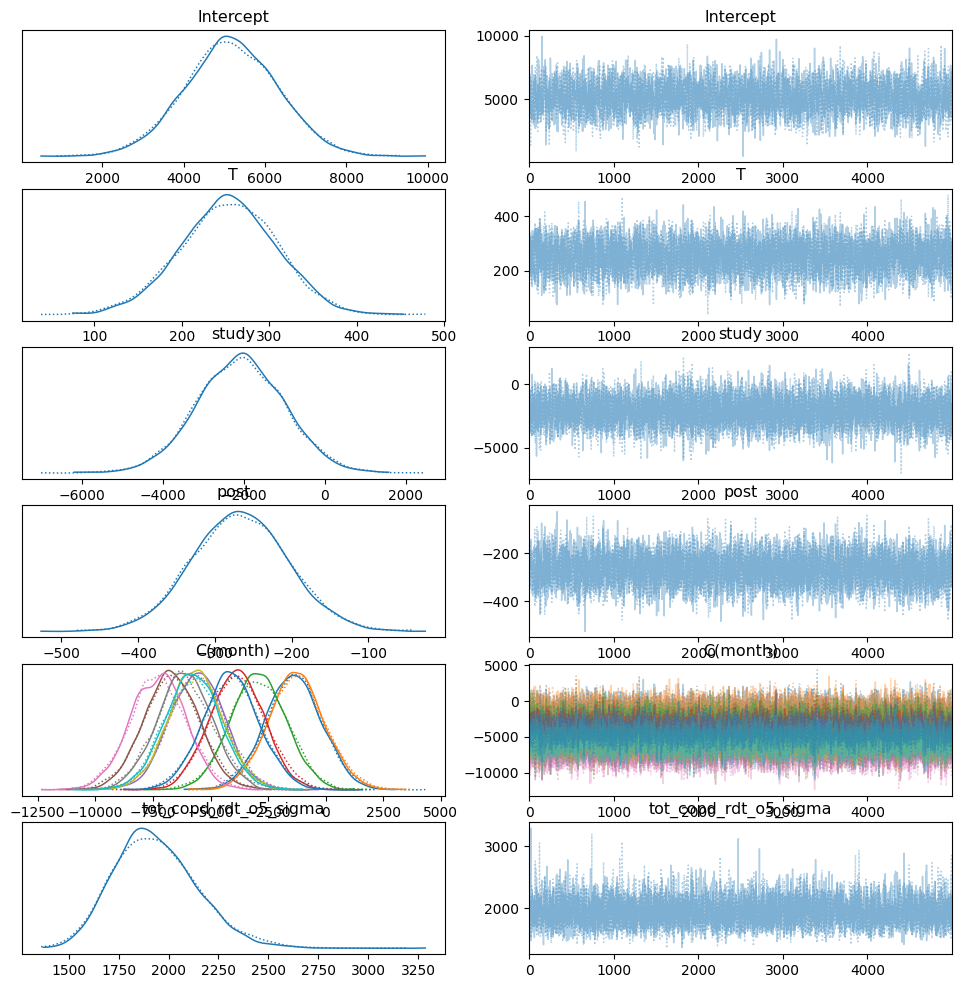

In [ ]:
# Plot the trace and results
print("The Bayesian ITSA Results")
az.plot_trace(result)
az.summary(result)

**Repeat for under 5**

In [ ]:
ci_inter_u = intervention[["tot_copd_rdt_u5"]].copy()
ci_inter_u["c_tot_copd_rdt_u5"] = control["tot_copd_rdt_u5"]
ci_inter_u["T"] = np.arange(len(ci_inter_u)) + 1
ci_inter_u["T"] = ci_inter_u["T"].astype(float)
ci_inter_u["study"] = np.where(ci_inter_u["T"] > 25, 1, 0)
ci_inter_u["post"] = (ci_inter_u["T"]-25 - 1).clip(lower=0)
ci_inter_u["month"] = ci_inter_u.index.month
ci_inter_u[:5]

,tot_copd_rdt_u5,c_tot_copd_rdt_u5,T,study,post,month
date2,,,,,,
2019-01-01,2365.0,3158.0,1.0,0,0.0,1
2019-02-01,1585.0,1709.0,2.0,0,0.0,2
2019-03-01,1062.0,1633.0,3.0,0,0.0,3
2019-04-01,923.0,1717.0,4.0,0,0.0,4
2019-05-01,939.0,1750.5,5.0,0,0.0,5


In [ ]:
model = bmb.Model(formula = "tot_copd_rdt_u5 ~ T + study + post +C(month)", data=ci_inter_u, dropna=True)
result = model.fit(draws=5000, chains=2)
print(result)

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data


The Bayesian ITSA Results


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1731.819,420.029,970.971,2544.075,7.259,5.133,3339.0,5440.0,1.0
T,112.478,20.478,75.393,152.059,0.275,0.196,5525.0,5963.0,1.0
study,-1052.040,391.516,-1778.703,-309.589,4.552,3.219,7394.0,7504.0,1.0
post,-135.247,23.537,-179.188,-90.186,0.289,0.206,6656.0,6494.0,1.0
C(month)[2],-512.988,454.892,-1417.575,304.722,7.584,5.363,3598.0,5505.0,1.0
C(month)[3],-432.233,453.688,-1318.273,386.528,7.826,5.534,3352.0,5515.0,1.0
C(month)[4],-1018.487,449.370,-1870.788,-177.556,7.697,5.443,3407.0,5286.0,1.0
C(month)[5],-1059.902,454.631,-1924.148,-205.332,7.658,5.415,3519.0,5901.0,1.0
C(month)[6],-1661.591,457.886,-2505.381,-794.092,7.630,5.396,3599.0,5925.0,1.0
C(month)[7],-2058.391,452.140,-2926.098,-1227.255,7.799,5.520,3361.0,5751.0,1.0


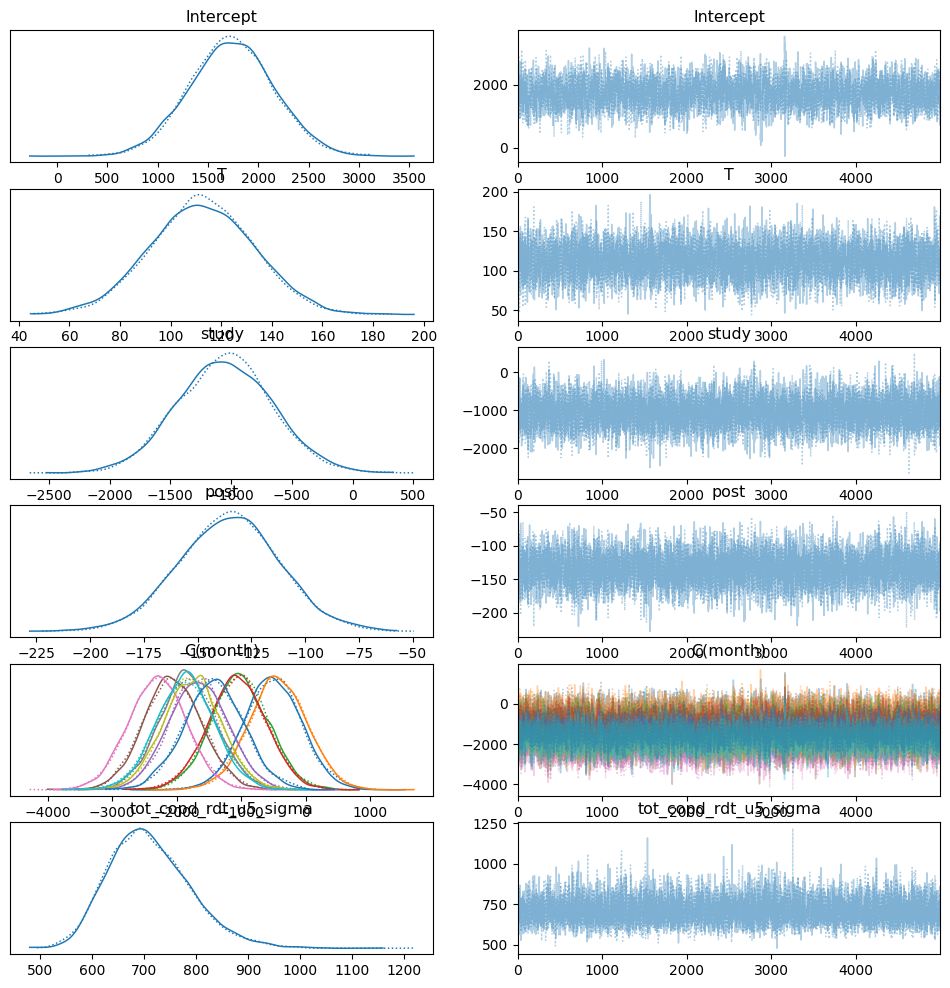

In [ ]:
# Plot the trace and results
print("The Bayesian ITSA Results")
az.plot_trace(result)
az.summary(result)

The results are similar to those obtained using the other two methods

# **Interrupted time series with control group**

In [ ]:
# This method typically suffers from attenuation bias. Subtract control from intervention
# Then run single ITSA
# Check directionality and magnitude
ci_inter["diff"] = ci_inter["c_tot_copd_rdt_o5"] - ci_inter["tot_copd_rdt_o5"]

In [ ]:
# This is an ITSA model with 1 lag and Newey-West Standard errors and without small sample correction
# The lag was chosen from a combination of the auto arima model, ACF and PACF plots above
model = smf.ols(formula = "diff ~ T + study + post +C(month)", data=ci_inter)
res = model.fit(cov_type="HAC", cov_kwds={"maxlags":1})
print("Interrupted time series analysis -- Over 5 RDT Confirmed")
print(res.summary())

Interrupted time series analysis -- Over 5 RDT Confirmed
                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     13.75
Date:                Mon, 25 Mar 2024   Prob (F-statistic):           7.06e-12
Time:                        14:33:39   Log-Likelihood:                -507.02
No. Observations:                  60   AIC:                             1044.
Df Residuals:                      45   BIC:                             1075.
Df Model:                          14                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

**Repeat for under-5**

In [ ]:
# Subtract control from intervention
# Then run single ITSA
# Check directionality and magnitude
ci_inter_u["diff"] = ci_inter_u["c_tot_copd_rdt_u5"] - ci_inter_u["tot_copd_rdt_u5"]

In [ ]:
# This is an ITSA model with 1 lag and Newey-West Standard errors and without small sample correction
# The lag was chosen from a combination of the auto arima model, ACF and PACF plots above
model = smf.ols(formula = "diff ~ T + study + post +C(month)", data=ci_inter_u)
res = model.fit(cov_type="HAC", cov_kwds={"maxlags":1})
print("Interrupted time series analysis -- Under 5 RDT Confirmed")
print(res.summary())

Interrupted time series analysis -- Under 5 RDT Confirmed
                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     10.10
Date:                Mon, 25 Mar 2024   Prob (F-statistic):           1.13e-09
Time:                        19:52:16   Log-Likelihood:                -457.32
No. Observations:                  60   AIC:                             944.6
Df Residuals:                      45   BIC:                             976.1
Df Model:                          14                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

The results are much higher than the estimates from the methods without a control group. Note that BSTS automatically incorporates controls.

# **Use ARIMA as a Robustness Check**

In [ ]:
#Recheck lags using the auto arima function
pm.auto_arima(ci_inter["tot_copd_rdt_o5"], error_action="ignore",
              trace=False, suppress_warnings=True, maxiter=10, seasonal=True, m=12)

ARIMA(maxiter=10, order=(1, 0, 0), scoring_args={},
      seasonal_order=(1, 0, 0, 12), suppress_warnings=True)

In [ ]:
# Check with ARIMA model
# Pre-empting reviewers: There are no Newey-West standard errors here
# ARIMA models already account for heteroscedasticity and autocorrelation
# Create dummy variables for each month
monthly_dummies = pd.get_dummies(ci_inter['month'], prefix='month')

# Concatenate the original dataframe with the monthly dummies
ci_inter_with_dummies = pd.concat([ci_inter, monthly_dummies], axis=1)

# Fit the ARIMA model with monthly dummies
arima_results = ARIMA(ci_inter_with_dummies["tot_copd_rdt_o5"],
                      ci_inter_with_dummies[["T", "study", "post"]].join(monthly_dummies),
                      order=(1, 0, 0), seasonal_order=(1,0,0,12)).fit()

print(arima_results.summary())


                                    SARIMAX Results                                     
Dep. Variable:                  tot_copd_rdt_o5   No. Observations:                   60
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -511.552
Date:                          Mon, 25 Mar 2024   AIC                           1061.104
Time:                                  14:42:28   BIC                           1100.897
Sample:                              01-01-2019   HQIC                          1076.669
                                   - 12-01-2023                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        790.4973   2103.510      0.376      0.707   -3332.306    4913.301
T            260.6318    129.228      2.017      0.

This is a bit of an overkill -- but similar results

In [ ]:
start = 26
end = 60
predictions = arima_results.get_prediction(0, end-1)
summary = predictions.summary_frame(alpha=.05)
y_pred = predictions.predicted_mean
arima_cf = ARIMA(ci_inter["tot_copd_rdt_o5"][:start],
                 ci_inter["T"][:start],
                 order=(1,0,0),
                 seasonal_order=(1,0,0,12)).fit()
y_pred = predictions.predicted_mean
y_cf = arima_cf.get_forecast(end - start, exog=ci_inter["T"][start:]
                            ).summary_frame(alpha=.05)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [ ]:
y_cf[:5]

tot_copd_rdt_o5,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-03-01,13068.035564,1372.156866,10378.657525,15757.413604
2021-04-01,12020.505634,1585.373800,8913.230083,15127.781185
2021-05-01,10263.236505,1650.639364,7028.042799,13498.430210
2021-06-01,7915.547288,1671.928788,4638.627079,11192.467496
2021-07-01,7350.626532,1678.998735,4059.849481,10641.403583


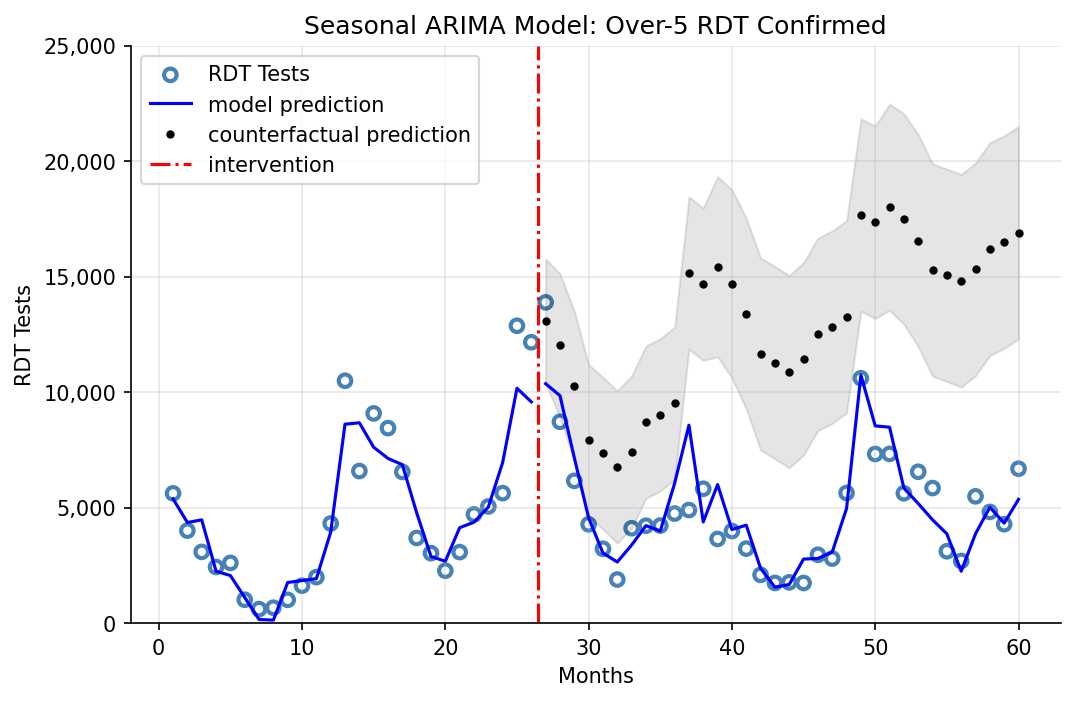

In [ ]:
# Plot SARIMA Predictions
fig, ax = plt.subplots(figsize=(8,5), dpi=150)
ax.scatter(ci_inter["T"], ci_inter["tot_copd_rdt_o5"], facecolors="none",
          edgecolors="steelblue", label="RDT Tests", linewidths=2)
ax.plot(ci_inter["T"][:start], y_pred[:start], "b-", label="model prediction")
ax.plot(ci_inter["T"][start:], y_pred[start:], "b-", )

ax.plot(ci_inter["T"][start:], y_cf["mean"], "k.", label="counterfactual prediction")
ax.fill_between(ci_inter["T"][start:],
                y_cf["mean_ci_lower"],
                y_cf["mean_ci_upper"],
                color="k", alpha=.1)
ax.axvline(x = start + .5, color = "r", linestyle="-.", label="intervention")
ax.legend(loc="upper left")
plt.ylim([0, 25_000])
plt.grid(axis="both", alpha=.3)
plt.xlabel("Months")
plt.ylabel("RDT Tests")
for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)

# Set the major formatter for y-axis labels using the custom function
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.title("Seasonal ARIMA Model: Over-5 RDT Confirmed");

Repeat for under-**5**

In [ ]:
#Recheck lags using the auto arima function
pm.auto_arima(ci_inter_u["tot_copd_rdt_u5"], error_action="ignore",
              trace=False, suppress_warnings=True, maxiter=10, seasonal=True, m=12)

ARIMA(maxiter=10, order=(1, 0, 0), scoring_args={},
      seasonal_order=(1, 0, 0, 12), suppress_warnings=True)

In [ ]:
# Check with ARIMA model
# Pre-empting reviewers: There are no Newey-West standard errors here
# ARIMA models already account for heteroscedasticity and autocorrelation
# Create dummy variables for each month
monthly_dummies = pd.get_dummies(ci_inter_u['month'], prefix='month')

# Concatenate the original dataframe with the monthly dummies
ci_inter_with_dummies = pd.concat([ci_inter_u, monthly_dummies], axis=1)

# Fit the ARIMA model with monthly dummies
arima_results = ARIMA(ci_inter_with_dummies["tot_copd_rdt_u5"],
                      ci_inter_with_dummies[["T", "study", "post"]].join(monthly_dummies),
                      order=(1, 0, 0), seasonal_order=(1,0,0,12)).fit()

print(arima_results.summary())

                                    SARIMAX Results                                     
Dep. Variable:                  tot_copd_rdt_u5   No. Observations:                   60
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -446.482
Date:                          Mon, 25 Mar 2024   AIC                            930.964
Time:                                  19:45:21   BIC                            970.756
Sample:                              01-01-2019   HQIC                           946.529
                                   - 12-01-2023                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        344.0315    485.256      0.709      0.478    -607.053    1295.116
T            117.1871     36.130      3.244      0.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
start = 26
end = 60
predictions = arima_results.get_prediction(0, end-1)
summary = predictions.summary_frame(alpha=.05)
y_pred = predictions.predicted_mean
arima_cf = ARIMA(ci_inter_u["tot_copd_rdt_u5"][:start],
                 ci_inter_u["T"][:start],
                 order=(1,0,0),
                 seasonal_order=(1,0,0,12)).fit()
y_pred = predictions.predicted_mean
y_cf = arima_cf.get_forecast(end - start, exog=ci_inter_u["T"][start:]
                            ).summary_frame(alpha=.05)
y_cf[:5]

tot_copd_rdt_u5,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-03-01,4905.592159,475.635929,3973.362869,5837.821449
2021-04-01,4609.202547,538.067762,3554.609112,5663.795982
2021-05-01,4332.804519,554.275625,3246.444257,5419.164781
2021-06-01,3824.348606,558.725595,2729.266562,4919.430649
2021-07-01,3471.833710,559.964138,2374.324168,4569.343252


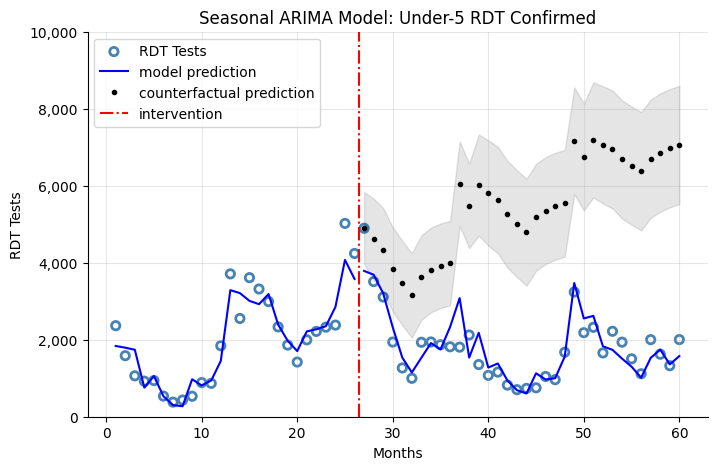

In [ ]:
# Plot SARIMA Predictions
fig, ax = plt.subplots(figsize=(8,5), dpi=100)
ax.scatter(ci_inter_u["T"], ci_inter_u["tot_copd_rdt_u5"], facecolors="none",
          edgecolors="steelblue", label="RDT Tests", linewidths=2)
ax.plot(ci_inter_u["T"][:start], y_pred[:start], "b-", label="model prediction")
ax.plot(ci_inter_u["T"][start:], y_pred[start:], "b-", )

ax.plot(ci_inter_u["T"][start:], y_cf["mean"], "k.", label="counterfactual prediction")
ax.fill_between(ci_inter_u["T"][start:],
                y_cf["mean_ci_lower"],
                y_cf["mean_ci_upper"],
                color="k", alpha=.1)
ax.axvline(x = start + .5, color = "r", linestyle="-.", label="intervention")
ax.legend(loc="upper left")
plt.ylim([0, 10_000])
plt.grid(axis="both", alpha=.3)
plt.xlabel("Months")
plt.ylabel("RDT Tests")
for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)

# Set the major formatter for y-axis labels using the custom function
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.title("Seasonal ARIMA Model: Under-5 RDT Confirmed")
plt.savefig("u5_rdt_arima.png", bbox_inches="tight");

In [ ]:
files.download("u5_rdt_arima.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Breakpoint Analysis

In [ ]:
# Breakpoint analysis to check if there are underlying things in the data
# Assume the COVID-19 pandemic was one of them
y = np.array(ci_inter["tot_copd_rdt_o5"].tolist())
model = rpt.Dynp(model="l1")
model.fit(y)
breaks = model.predict(n_bkps=3)
breaks_rpt = []
for i in breaks:
  breaks_rpt.append(ci_inter.index[i-1])
breaks_rpt = pd.to_datetime(breaks_rpt)
breaks_rpt

DatetimeIndex(['2019-10-01', '2022-04-01', '2022-09-01', '2023-12-01'], dtype='datetime64[ns]', freq=None)

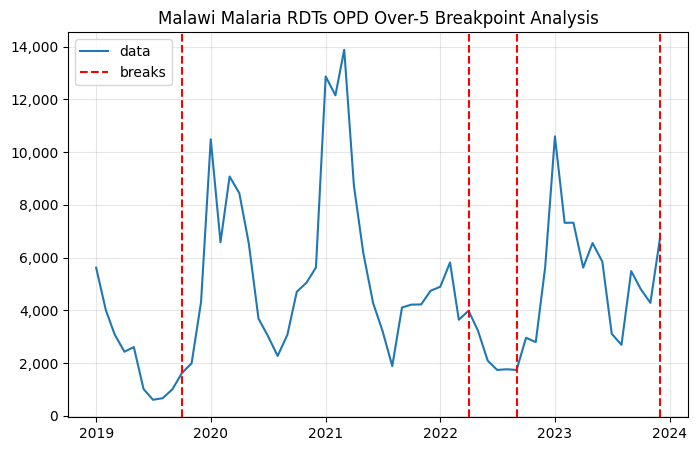

In [ ]:
# Plot the breakpoints
fig,ax =plt.subplots(figsize=(8,5), dpi=100)
plt.plot(ci_inter.index, ci_inter["tot_copd_rdt_o5"], label='data')
plt.title('Malawi Malaria RDTs OPD Over-5 Breakpoint Analysis')
print_legend = True
for i in breaks_rpt:
    if print_legend:
        plt.axvline(i, color='red',linestyle='dashed', label='breaks')
        print_legend = False
    else:
        plt.axvline(i, color='red',linestyle='dashed')
plt.grid(axis = "both", alpha=.3)
plt.legend(loc = "best")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.savefig("breakpoint.png", bbox_inches="tight")

In [ ]:
files.download("breakpoint.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Discuss with Malawi team if there were other policy issues or events around the structural breaks.

# Date Falsification Checks.

We use this to see if varying the dates before and after the actual
start of the study has an impact on the results.

In [ ]:
ci_inter["tot_copd_rdt_u5"] = intervention["tot_copd_rdt_u5"]
ci_inter["T"] = np.arange(len(ci_inter)) + 1
ci_inter["T"] = ci_inter["T"].astype(float)
ci_inter["study"] = np.where(ci_inter["T"] > 25, 1, 0)
ci_inter["post"] = (ci_inter["T"]-25 - 1).clip(lower=0)
ci_inter["month"] = ci_inter.index.month

In [ ]:
# Create new columns for study and post variables
for i in range(21, 31):
    ci_inter[f'study_{i}'] = np.where(ci_inter['T'] == i, 1, 0)
    ci_inter[f'post_{i}'] = (ci_inter['T'] - i).clip(lower=0)

# Create a list of column names to iterate over
study_cols = [f'study_{i}' for i in range(21, 31)]  # study_21 to study_30
post_cols = [f'post_{i}' for i in range(21, 31)]  # post_21 to post_30

# Create an empty list to store the regression results
regression_results = []
study_coef_info = []

# Iterate over the column names
for study_col, post_col in zip(study_cols, post_cols):
    # Construct the formula string dynamically
    formula_str = "tot_copd_rdt_u5 ~ T + {} + {} + C(month)".format(study_col, post_col)

    # Fit the regression model
    model = smf.ols(formula=formula_str, data=ci_inter)
    results = model.fit()

    # Store the results in the list
    regression_results.append(results)

    # Extract coefficient information for the study variable
    study_coef = results.params[study_col]
    study_pval = results.pvalues[study_col]
    study_conf_int = results.conf_int(alpha=0.05).loc[study_col]
    study_ci_lower = study_conf_int[0]
    study_ci_upper = study_conf_int[1]
    study_coef_info.append([study_coef, study_pval, study_ci_lower, study_ci_upper])

# You can now access the regression results for each combination of study and post columns
for i, result in enumerate(regression_results):
    print(f"Regression {i+1} Results:")
    print(result.summary())

# Print the coefficient information for the study variable
print(f"Study Variable Coefficient Info: {study_coef_info[i]}")

Regression 1 Results:
                            OLS Regression Results                            
Dep. Variable:        tot_copd_rdt_u5   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     6.016
Date:                Mon, 25 Mar 2024   Prob (F-statistic):           1.84e-06
Time:                        20:45:03   Log-Likelihood:                -470.52
No. Observations:                  60   AIC:                             971.0
Df Residuals:                      45   BIC:                             1002.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1847.3

In [ ]:
# Transform the date falsification results into a pandas dataframe for easy visualization
# Also add a column for date
falsification_tests = pd.DataFrame(study_coef_info, columns=["Coefficient", "P-Value", "Lower CI", "Upper CI"])
falsification_tests["Date"] = ci_inter.index[21:31].strftime("%Y-%m").tolist()
col_order = ["Date"] + [col for col in falsification_tests.columns if col != "Date"]
falsification_tests = falsification_tests.reindex(columns=col_order)
falsification_tests[:]
#study_coef_info[0][2][0]

,Date,Coefficient,P-Value,Lower CI,Upper CI
0,2020-10,-520.393408,2.039717e-01,-1333.500072,292.713257
1,2020-11,-606.293858,1.398408e-01,-1418.794376,206.206661
2,2020-12,-746.254415,7.060494e-02,-1557.863345,65.354514
3,2021-01,-750.948105,7.304165e-02,-1574.956133,73.059923
4,2021-02,-1096.713278,6.818394e-03,-1875.526498,-317.900059
5,2021-03,-1406.630024,3.535808e-04,-2139.559092,-673.700957
6,2021-04,-1874.009467,4.984305e-07,-2517.777672,-1230.241262
7,2021-05,-2110.333803,5.969961e-09,-2704.239749,-1516.427858
8,2021-06,-2259.603726,3.209897e-10,-2826.978995,-1692.228456
9,2021-07,-2269.001025,8.114615e-10,-2859.037328,-1678.964722


In [ ]:
ci_inter_u[:5]

,tot_copd_rdt_u5,c_tot_copd_rdt_u5,T,study,post,month,diff
date2,,,,,,,
2019-01-01,2365.0,3158.0,1.0,0,0.0,1,793.0
2019-02-01,1585.0,1709.0,2.0,0,0.0,2,124.0
2019-03-01,1062.0,1633.0,3.0,0,0.0,3,571.0
2019-04-01,923.0,1717.0,4.0,0,0.0,4,794.0
2019-05-01,939.0,1750.5,5.0,0,0.0,5,811.5


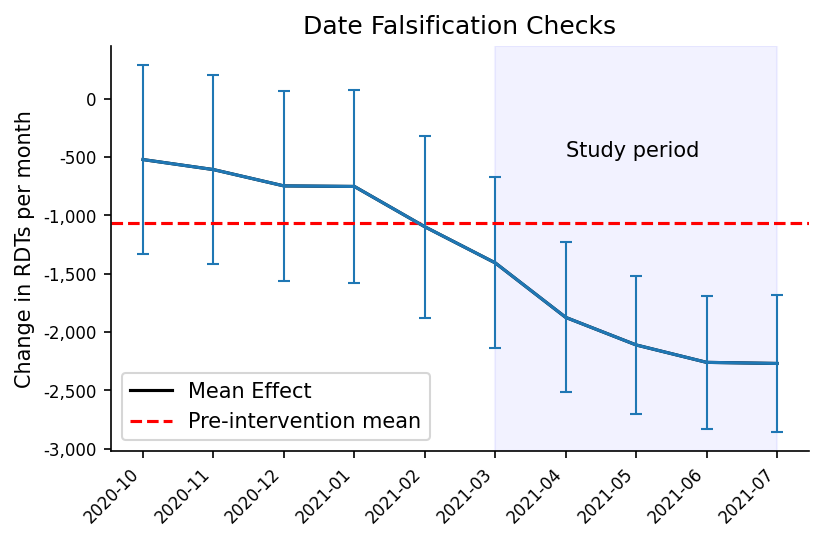

In [ ]:
# Generate mean difference in the pre-intervention period
# Need to round it to use for plotting
pre_mean = int(ci_inter_u["tot_copd_rdt_u5"][:26].mean() -
               ci_inter_u["c_tot_copd_rdt_u5"][:26].mean())
fig, ax = plt.subplots(figsize=(6,3.5), dpi=150)
plt.title("Date Falsification Checks")
plt.plot(falsification_tests["Date"], falsification_tests["Coefficient"],
         label="Mean Effect", color="k")
plt.errorbar(falsification_tests["Date"],
             falsification_tests["Coefficient"],
             yerr=[falsification_tests["Coefficient"] - falsification_tests["Lower CI"],
                   falsification_tests["Upper CI"] - falsification_tests["Coefficient"]],
            capsize=3, elinewidth=1, capthick=1
             )
plt.axhline(pre_mean, ls="--", color="red", label="Pre-intervention mean")
plt.axvspan(5,9, color="blue", alpha=.05)
plt.xticks(rotation=45, ha="right")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.ylabel("Change in RDTs per month")
for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
plt.legend(loc="best")
plt.text(6, -500, "Study period")
ax.tick_params(labelsize=8)
plt.savefig("falsification.png", bbox_inches="tight");

In [ ]:
files.download("falsification.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Note: While the ITSA methods above indicate that there was an effect of around -2100 (decline in RDTs in over-5s) following the intervention, the date falsification tests suggest that the change in trends started a month earlier i.e. in February 2021. In the graph above, the mean difference line is set at the difference in pre-intervention period means which is 1,063.

In [ ]:
cd "/content/drive/MyDrive/Colab Notebooks"

[Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks'
/content


In [ ]:
cd "/content"

/content


In [1]:
#!jupyter nbconvert --to html "Copy of MCCM_TSA.ipynb"

In [ ]:
 from google.colab import drive

 drive.mount('/content/gdrive')

Mounted at /content/gdrive
